<a href="https://colab.research.google.com/github/minnji88/DeepLearning2020/blob/master/3_6_%EC%A3%BC%ED%83%9D%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1_%ED%9A%8C%EA%B7%80%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 보스턴 주택 가격 데이터셋

회귀(regression) = 개별적인 레이블이 아닌 연속적인 값을 예측

404개의 훈련 샘플, 102개의 테스트 샘플


입력 데이터의 특성의 스케일이 서로 다름. ([0,1],[1,12],[1,100] 등)


13개의 특성을 가짐

In [8]:
# 코드 3-24 보스턴 주택 데이터셋 로드하기
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()
print(train_data)

[[1.23247e+00 0.00000e+00 8.14000e+00 ... 2.10000e+01 3.96900e+02
  1.87200e+01]
 [2.17700e-02 8.25000e+01 2.03000e+00 ... 1.47000e+01 3.95380e+02
  3.11000e+00]
 [4.89822e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.75520e+02
  3.26000e+00]
 ...
 [3.46600e-02 3.50000e+01 6.06000e+00 ... 1.69000e+01 3.62250e+02
  7.83000e+00]
 [2.14918e+00 0.00000e+00 1.95800e+01 ... 1.47000e+01 2.61950e+02
  1.57900e+01]
 [1.43900e-02 6.00000e+01 2.93000e+00 ... 1.56000e+01 3.76700e+02
  4.38000e+00]]


##  데이터 준비

특성별로 정규화(표준화)가 필요

각 특성을 특성의 평균을 빼고 표준 편차로 나눕니다. 그렇다면 특성의 평균은 0, 표준 편차는 1인 데이터셋으로 만들어집니다. 
본 정규화는 *훈련 데이터 값* 만 이용해야 함을 주의해야합니다.


In [9]:
# 코드 3-25 데이터 정규화하기
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

print(len(train_data))

404


## 모델 구성

샘플 개수가 적어 64개의 유닛을 가진 2개의 은닉 층으로 네트워크르 구성합니다.


출력에 dense에 활성화 함수가 없음

평균 제곱 오차(mse) 손실 함수를 이용함 | 
평균 절대 오차(MAE) 로 모니터링함 (예측과 타깃의 절대적 거리)

In [10]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

##  K-겹 검증을 사용한 훈련 검증

데이터를 K개의 fold로 나누고, K개의 모델을 만듬

각각의 모델에서 K-1개의 분할에서 훈련하고, 나머지 분할에서 평가

모델의 검증 점수는 K개의 검증 점수 평균

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [13]:
all_scores

[2.336118459701538, 2.685135841369629, 2.949312925338745, 2.217306137084961]

In [14]:
np.mean(all_scores)

2.5469683408737183

In [15]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [16]:
# 코드 3-28 각 폴드에서 검증 점수를 로그에 저장하기
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]  #검증 데이터 준비: k번째 분할    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(  # 훈련 데이터 준비: 다른 분할 전체
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()  # 케라스 모델 구성(컴파일 포함)
    history = model.fit(partial_train_data, partial_train_targets,  # 모델 훈련(verbose=0이므로 훈련 과정이 출력되지 않습니다.)
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [17]:
# 코드 3-29 k-겹 검증 점수 평균을 기록하기
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

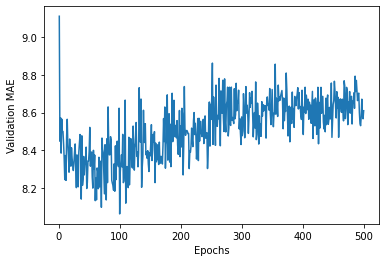

In [18]:
# 코드 3-30 검증 점수 그래프
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

fig5 = plt.gcf()

plt.draw()
fig5.savefig('fig5.png', dpi=100)

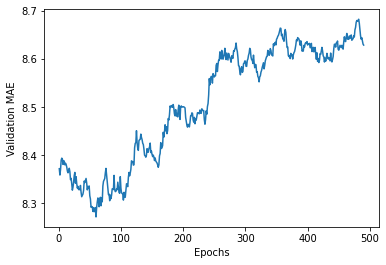

In [19]:
# 코드 3-31 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [20]:
# 코드 3-32 최종 모델 훈련하기
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 17.0484 - mae: 2.7153
2.7153100967407227


회귀에서는 평균 제곱 오차를 손실 함수를 자주 사용

평가 지표는 평균 절대 오차를 일반적으로 사용

특성 스케일이 다른 경우, 스케일을 전처리 단계에서 조정

가용 데이터가 적은 경우 K-겹 검증 사용

훈련 데이터가 적다면 오버피팅을 피하기 위하여 은닉 층을 줄임